# QSO 在RTX亚型中问题

## 开始干正事：画图

In [1]:
import sys
sys.path.append("src")
import os
import json

import libpybiofeature

import utils
work_Dir = utils.workdir.workdir(os.getcwd(), 4)

import numpy as np
import pandas as pd

from Bio import SeqIO, Seq

random_seed = 42
np.random.seed(random_seed)

In [2]:
def load_QSO_feature(TxSE_args: dict):

    # QSO
    QSO_feature = {
        "name": "QSO",
        "p": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['p'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['p'], "fasta") ],
            desc='p',
            cter=TxSE_args['fasta']['cter']
        ),
        "n": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['n'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['n'], "fasta") ],
            desc='n',
            cter=TxSE_args['fasta']['cter']
        ),
    }

    print(QSO_feature['n'].shape[0], QSO_feature['p'].shape[0])

    return QSO_feature

In [3]:
prot_type = 2
cter_bool = False
Tx_arg = {
    "type": f'T{prot_type}',
    'fasta': {
        'cter': cter_bool,
        'p': "data/T2SE/spT2SE.fasta",
        'n': "data/T2SE/sp_paired_non_t2se.fasta"
    },
}
save_dir = "out/libfeatureselection/Second_feature_research/qso/sp"

In [4]:
qso_data = load_QSO_feature(
    TxSE_args=Tx_arg
)
columns_type = list(qso_data['p'].columns)

n_QSO: 100%|██████████| 44/44 [00:00<00:00, 242.38it/s]

44 44


In [5]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.use14corefonts'] = False
# mpl.rcParams['pdf.usecorefonts'] = True
mpl.rcParams['pdf.compression'] = 9

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'nature'])

from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

import seaborn as sns

In [6]:
qso_data_transformed = pd.concat([qso_data['p'], qso_data['n']], keys=['T1SP', 'non-T1SP']).reset_index(level=0).rename({
    "level_0": "Type"
}, axis=1, inplace=False).melt(id_vars="Type", value_vars=columns_type, ignore_index=False).rename({
    "variable": "Columns",
    "value": "QSO"
}, axis=1, inplace=False)
qso_data_transformed['Columns'] = qso_data_transformed['Columns'].str.replace(r'Schneider', 'S', regex=True).replace(r'Grantham', 'G', regex=True)

In [7]:
qso_data_transformed

,Type,Columns,QSO
CAP52973.1,T1SP,S.Xr.A,0.127385
AFI68360.1,T1SP,S.Xr.A,0.095955
AAF94613.1,T1SP,S.Xr.A,0.112477
AAA24847.1,T1SP,S.Xr.A,0.101706
WP_013318538.1,T1SP,S.Xr.A,0.117827
...,...,...,...
lcl|NC_009052.1_prot_WP_011847302.1_2955,non-T1SP,G.Xd.30,0.032671
lcl|NC_022000.1_prot_WP_004244295.1_2242,non-T1SP,G.Xd.30,0.029477
lcl|NC_015408.1_prot_WP_013712626.1_499,non-T1SP,G.Xd.30,0.032174
lcl|FN554766.1_prot_CBG37577.1_4743,non-T1SP,G.Xd.30,0.009892


In [9]:
def get_star(p:float):
    if p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return ""
from scipy.stats import wilcoxon
grouped = qso_data_transformed.groupby("Columns")
wilcoxon_result = {}
for name, group in grouped:
    x = group[group['Type'] == 'T1SP']['QSO']
    y = group[group['Type'] == 'non-T1SP']['QSO']
    stat, p = wilcoxon(x, y)
    wilcoxon_result[name] = {
        "statistic": stat,
        "p-value": p
    }
    # print(f'Type: {name}, Wilcoxon rank-sum statistic: {stat:.2f}, p-value: {p:.3f}')
with open(f"{save_dir}/wilcoxon_result.json", "w+", encoding="UTF-8") as f:
    json.dump(wilcoxon_result, f)
qso_data_transformed.to_csv(f"{save_dir}/qso_data_transformed.csv", index_label="Seq_ID")

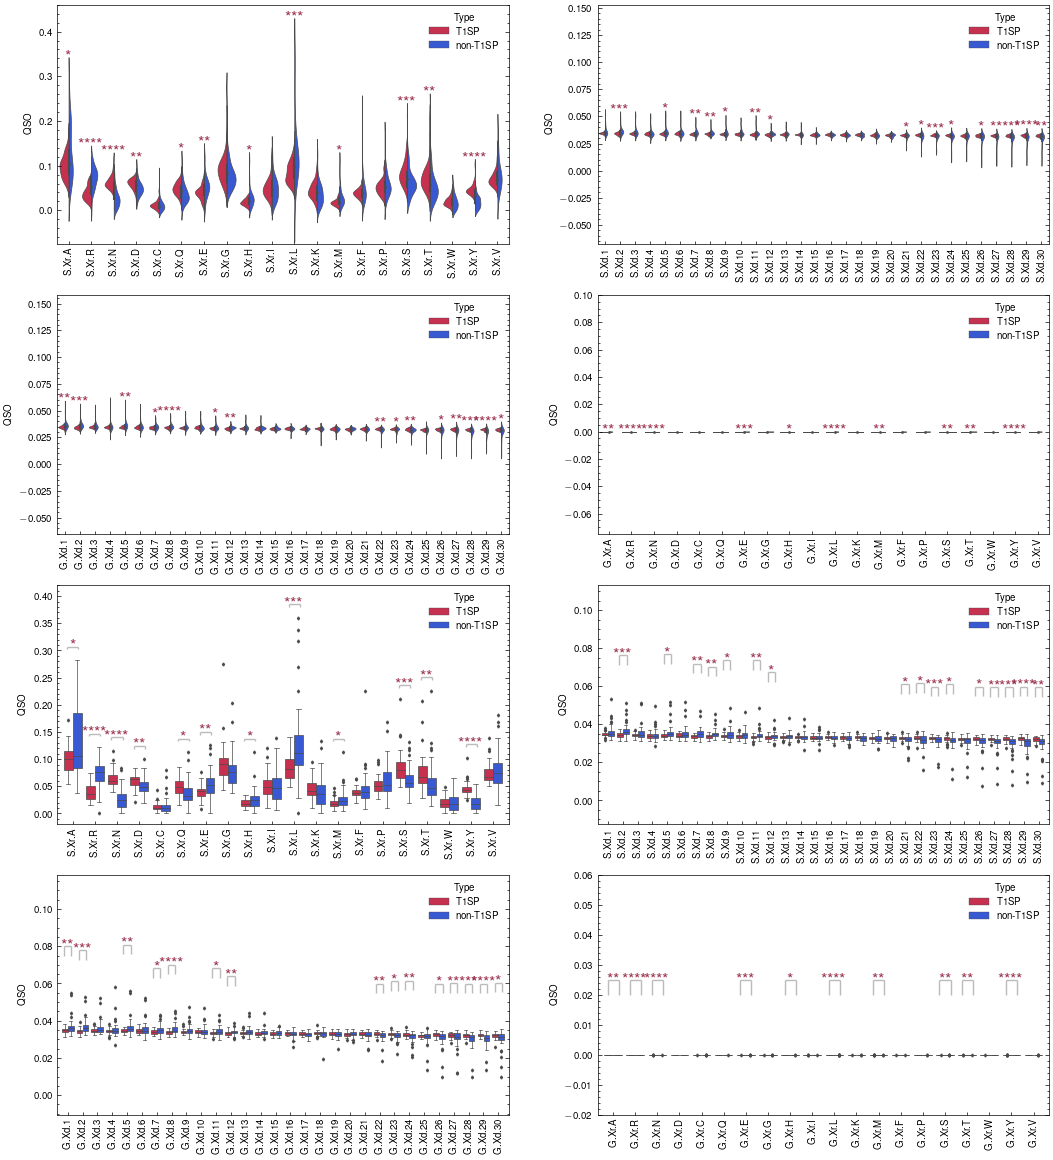

In [10]:
ncols = 2
nrow = 4
fig = plt.figure(
    constrained_layout=True,
    figsize=(19.2 / 4 * 1.35 * ncols, 10.8 / 4 * 1.35 * nrow)
)
gs = GridSpec(nrow, ncols, figure=fig)

# Schneider.Xr
qso_data_transformed_Schneider = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'S\.Xr\.\w', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[0, 0])

sns.violinplot(
    data=qso_data_transformed_Schneider,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_Schneider['QSO'].min() - 0.075, qso_data_transformed_Schneider['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[2, 0])

sns.boxplot(
    data=qso_data_transformed_Schneider,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_Schneider['QSO'].min() - 0.02, qso_data_transformed_Schneider['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_Schneider[qso_data_transformed_Schneider["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# Schneider.Xd
qso_data_transformed_SchneiderXd = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'S\.Xd\.\d+', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[0, 1])

sns.violinplot(
    data=qso_data_transformed_SchneiderXd,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_SchneiderXd['QSO'].min() - 0.075, qso_data_transformed_SchneiderXd['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[2, 1])

sns.boxplot(
    data=qso_data_transformed_SchneiderXd,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_SchneiderXd['QSO'].min() - 0.02, qso_data_transformed_SchneiderXd['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_SchneiderXd[qso_data_transformed_SchneiderXd["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# Grantham.Xd
qso_data_transformed_GranthamXd = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'G\.Xd\.\d+', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[1, 0])

sns.violinplot(
    data=qso_data_transformed_GranthamXd,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_GranthamXd['QSO'].min() - 0.075, qso_data_transformed_GranthamXd['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[3, 0])

sns.boxplot(
    data=qso_data_transformed_GranthamXd,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_GranthamXd['QSO'].min() - 0.02, qso_data_transformed_GranthamXd['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_GranthamXd[qso_data_transformed_GranthamXd["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# Grantham.Xr
qso_data_transformed_GranthamXr = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'G\.Xr\.\w', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[1, 1])

sns.violinplot(
    data=qso_data_transformed_GranthamXr,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_GranthamXr['QSO'].min() - 0.075, qso_data_transformed_GranthamXr['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[3, 1])

sns.boxplot(
    data=qso_data_transformed_GranthamXr,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_GranthamXr['QSO'].min() - 0.02, qso_data_transformed_GranthamXr['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_GranthamXr[qso_data_transformed_GranthamXr["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")


# plt.title("AAC Training-Testing Wilcoxon Signed Ranks Test")
plt.savefig(f"{save_dir}/diff.pdf")
plt.tight_layout()
plt.show()

# 构建RTX-AAC模型预测non-RTX蛋白

In [11]:
import sys
sys.path.append("src")
import os
os.environ["n_jobs"] = "2"
import json

import libpybiofeature

import utils
work_Dir = utils.workdir.workdir(os.getcwd(), 4)

import numpy as np
import pandas as pd

from Bio import SeqIO

random_seed = 42
np.random.seed(random_seed)

In [12]:
from sklearn.model_selection import StratifiedKFold

In [13]:
def load_QSO_feature(TxSE_args: dict):

    # QSO
    QSO_feature = {
        "name": "QSO",
        "p": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['p'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['p'], "fasta") ],
            desc='p',
            cter=TxSE_args['fasta']['cter']
        ),
        "n": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['n'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['n'], "fasta") ],
            desc='n',
            cter=TxSE_args['fasta']['cter']
        ),
    }

    # # 一般p会少于n，所以随机在n中选择即可
    # QSO_feature['n'] = QSO_feature['n'].iloc[np.random.choice(
    #     np.arange(QSO_feature['n'].shape[0]), 
    #     size=QSO_feature['p'].shape[0], 
    #     replace=False
    # ), :]

    QSO_feature["pn_all_feature"] = pd.concat([
        QSO_feature["p"],
        QSO_feature["n"],
    ])
    QSO_feature["pn_all_label"] = np.concatenate([
        np.ones(shape=(QSO_feature["p"].shape[0], )),
        np.zeros(shape=(QSO_feature["n"].shape[0], )),
    ])

    # 切割train、test
    train_id, test_id = next(iter(StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ).split(
        QSO_feature["pn_all_feature"].values,
        QSO_feature["pn_all_label"]
    )))

    QSO_feature["training_pn_all_feature"] = QSO_feature["pn_all_feature"].iloc[train_id, :]
    QSO_feature["training_pn_all_label"] = QSO_feature["pn_all_label"][train_id]
    QSO_feature["testing_pn_all_feature"] = QSO_feature["pn_all_feature"].iloc[test_id, :]
    QSO_feature["testing_pn_all_label"] = QSO_feature["pn_all_label"][test_id]

    return QSO_feature

In [14]:
prot_type = 2
cter_bool = False
rtx_Tx_arg = {
    "type": f'T{prot_type}',
    'fasta': {
        'cter': cter_bool,
        'p': "data/T2SE/spT2SE.fasta",
        'n': "data/T2SE/sp_paired_non_t2se.fasta"
    },
}
nonrtx_Tx_arg = {
    "type": f'T{prot_type}',
    'fasta': {
        'cter': cter_bool,
        'p': "data/T2SE/nospT2SE.fasta",
        'n': "data/T2SE/nosp_paired_non_t2se.fasta"
    },
}
model_save_dir = "out/libfeatureselection/Second_feature_research/qso/sp/model"
os.makedirs(model_save_dir, exist_ok=True)

In [15]:
rtx_qso_data = load_QSO_feature(
    TxSE_args=rtx_Tx_arg
)
nonrtx_qso_data = load_QSO_feature(
    TxSE_args=nonrtx_Tx_arg
)
qso_type = list(rtx_qso_data['p'].columns)
print(rtx_qso_data.keys(), ", ".join(qso_type))

n_QSO: 100%|██████████| 11/11 [00:00<00:00, 275.86it/s]

dict_keys(['name', 'p', 'n', 'pn_all_feature', 'pn_all_label', 'training_pn_all_feature', 'training_pn_all_label', 'testing_pn_all_feature', 'testing_pn_all_label']) Schneider.Xr.A, Schneider.Xr.R, Schneider.Xr.N, Schneider.Xr.D, Schneider.Xr.C, Schneider.Xr.Q, Schneider.Xr.E, Schneider.Xr.G, Schneider.Xr.H, Schneider.Xr.I, Schneider.Xr.L, Schneider.Xr.K, Schneider.Xr.M, Schneider.Xr.F, Schneider.Xr.P, Schneider.Xr.S, Schneider.Xr.T, Schneider.Xr.W, Schneider.Xr.Y, Schneider.Xr.V, Grantham.Xr.A, Grantham.Xr.R, Grantham.Xr.N, Grantham.Xr.D, Grantham.Xr.C, Grantham.Xr.Q, Grantham.Xr.E, Grantham.Xr.G, Grantham.Xr.H, Grantham.Xr.I, Grantham.Xr.L, Grantham.Xr.K, Grantham.Xr.M, Grantham.Xr.F, Grantham.Xr.P, Grantham.Xr.S, Grantham.Xr.T, Grantham.Xr.W, Grantham.Xr.Y, Grantham.Xr.V, Schneider.Xd.1, Schneider.Xd.2, Schneider.Xd.3, Schneider.Xd.4, Schneider.Xd.5, Schneider.Xd.6, Schneider.Xd.7, Schneider.Xd.8, Schneider.Xd.9, Schneider.Xd.10, Schneider.Xd.11, Schneider.Xd.12, Schneider.Xd.13, Sc

In [16]:
from libfeatureselection import model, model_space
n_jobs = (
    (os.cpu_count() - 2)
    if "n_jobs" not in os.environ or os.environ['n_jobs'] == "" else
    int(os.environ['n_jobs'])
)
n_jobs

2023-07-06 18:08:28.330734: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 18:08:28.333020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-06 18:08:28.333028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-06 18:08:28.831297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-06 18:08:28.831312: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to c

2

In [17]:
search_result_in_a_scheme_df = pd.DataFrame()
for model_index in range(len(model_space.find_space)):
    model_information_summary, searched_result_performance_summary, searched_result_5C_performance_summary = model.MyOptimitzer(
        classifier_name=model_space.find_space[model_index]['name'],
        classifier_class=model_space.find_space[model_index]['class'],
        classifier_param_dict=model_space.find_space[model_index]['param'],
    ).find_best(
        X=rtx_qso_data["pn_all_feature"].values,
        y=rtx_qso_data["pn_all_label"],
        validation=(
            nonrtx_qso_data["pn_all_feature"].values,
            nonrtx_qso_data["pn_all_label"]
        ),
        search_method=(
            "BayesSearchCV"
            if "Bayes" not in model_space.find_space[model_index]
            or model_space.find_space[model_index]['Bayes'] == True
            else "GridSearchCV"
        ),
        n_jobs=n_jobs
    ).get_summary(
        path_to_dir=f"{model_save_dir}/model/"
    )

    # 记录结果，插入到 search_result_in_a_scheme_df
    result_series = pd.concat([
        pd.Series(model_information_summary),
        pd.Series(searched_result_performance_summary),
        pd.Series(searched_result_5C_performance_summary),
    ], keys=[
        "Model_Information",
        "Best_Performance",
        "5FoldCV_Performance",
    ])

    result_series.name = model_index

    search_result_in_a_scheme_df = pd.concat([
        search_result_in_a_scheme_df,
        result_series.to_frame().T
    ], axis=0, ignore_index=False)

    search_result_in_a_scheme_df.index = search_result_in_a_scheme_df.index.set_names(
        ["Model_Type",]
    )

    local_xlsx_path = f"{model_save_dir}/searched_result.xlsx"

    # 缓存 search_result_in_a_scheme_df
    search_result_in_a_scheme_df.to_excel(
        local_xlsx_path,
        "RTX-model_Predict_non-RTX",
        freeze_panes=(2, 1)
    )

/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/model_selection/_validatio

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>